# Daylight Saving Effect on Heart Attack

We will use the [healthcare dataset from Kaggle](https://www.kaggle.com/datasets/prasad22/healthcare-dataset).

In [208]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dowhy.causal_identifier import backdoor
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.models import BayesianModel
import dowhy
from dowhy import CausalModel
import os

from warnings import filterwarnings
filterwarnings('ignore')

# Motivation and Data Processing - 10% of the grade

Motivation, description of dataset and causal questions, description of assumptions, show true causal graph or a reasonable guess (10% grade)

In [209]:
# Move up one directory from the current working directory
os.chdir('..')

# Navigate to the 'data' directory
os.chdir('data')

file_path = 'healthcare/healthcare_dataset.csv'
# currently folder/heartattack
df = pd.read_csv(file_path)

We only consider the first visit of patients with hypertension.

In [210]:
filtered_df = df[df['Medical Condition'] == 'Hypertension']
filtered_df = filtered_df[~filtered_df['Name'].duplicated(keep='first')]

Let's see how many unique values each variable has.

In [211]:
for col_name in filtered_df.columns:
    print(f'{col_name}:{filtered_df[col_name].nunique()}')

Name:1668
Age:68
Gender:2
Blood Type:8
Medical Condition:1
Date of Admission:1113
Doctor:1643
Hospital:1597
Insurance Provider:5
Billing Amount:1668
Room Number:396
Admission Type:3
Discharge Date:1088
Medication:5
Test Results:3


We decide that the following variables are irrelevant for our analysis or have arbitrary data: ```['Doctor', 'Hospital', 'Room Number', 'Discharge Date']```. We can also drop ```'Name'``` since we already filtered by the first visit of unique individuals.

In [212]:
filtered_df = filtered_df.drop(columns=['Doctor', 'Hospital', 'Room Number', 'Discharge Date', 'Name'])

Let's see the unique values of the columns with less than 10 unique values. We print the column names contianing continuous data.

In [213]:
categoricals = []

for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(f'{col_name}:{filtered_df[col_name].unique()}')
        categoricals.append(col_name)
    else:
        print(f'{col_name} is a continuous variable.')

Age is a continuous variable.
Gender:['Male' 'Female']
Blood Type:['AB+' 'O-' 'O+' 'A+' 'A-' 'B-' 'B+' 'AB-']
Medical Condition:['Hypertension']
Date of Admission is a continuous variable.
Insurance Provider:['Cigna' 'Medicare' 'UnitedHealthcare' 'Aetna' 'Blue Cross']
Billing Amount is a continuous variable.
Admission Type:['Urgent' 'Emergency' 'Elective']
Medication:['Lipitor' 'Paracetamol' 'Aspirin' 'Ibuprofen' 'Penicillin']
Test Results:['Abnormal' 'Inconclusive' 'Normal']


We aim to introduce a binary column: assigning a value of 1 if the admission date falls within a 3-month window surrounding the annual daylight saving time change in March (a period during which individuals typically adjust their schedules due to a one-hour reduction in sleep), and 0 otherwise. Our dataset spans the years 2018-2023, and we construct a dictionary pairing each year with the specific date of the daylight saving time transition.

In [214]:
daylight_saving_dates = {
    2018: '2018-03-25',
    2019: '2019-03-31',
    2020: '2020-03-29',
    2021: '2021-03-28',
    2022: '2022-03-27',
    2023: '2023-03-26'}

In [215]:
daylight_saving_dates = {year: pd.to_datetime(date) for year, date in daylight_saving_dates.items()}

filtered_df['daylight_saving_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[pd.to_datetime(date).year] <= pd.to_datetime(date) <= daylight_saving_dates[pd.to_datetime(date).year] + pd.DateOffset(months=3)
                                                                        else 0)

filtered_df['daylight_saving_before_march'] = filtered_df['Date of Admission'].apply(lambda date: 1 
                                                                        if daylight_saving_dates[pd.to_datetime(date).year] >= pd.to_datetime(date) >= daylight_saving_dates[pd.to_datetime(date).year] - pd.DateOffset(months=3)
                                                                        else 0)

Let's see how balanced is our data.

In [216]:
for col_name in filtered_df.columns:
    if filtered_df[col_name].nunique() <= 10:
        print(filtered_df[col_name].value_counts())
        print()

Male      842
Female    826
Name: Gender, dtype: int64

AB-    221
A+     212
A-     211
B+     209
O+     208
AB+    207
O-     205
B-     195
Name: Blood Type, dtype: int64

Hypertension    1668
Name: Medical Condition, dtype: int64

Cigna               352
Aetna               341
Medicare            334
UnitedHealthcare    321
Blue Cross          320
Name: Insurance Provider, dtype: int64

Urgent       589
Emergency    571
Elective     508
Name: Admission Type, dtype: int64

Lipitor        353
Penicillin     343
Ibuprofen      333
Aspirin        322
Paracetamol    317
Name: Medication, dtype: int64

Abnormal        593
Inconclusive    546
Normal          529
Name: Test Results, dtype: int64

0    1247
1     421
Name: daylight_saving_march, dtype: int64

0    1295
1     373
Name: daylight_saving_before_march, dtype: int64



We notice that 25% of Hypertension cases happen within 3 months after the daylight saving in March, whil 22% of the hypertension cases happen before the daylight saving time. Of course this is not enough, we shall see if the daylight saving actually affects the changes of getting hypertension. We come with our own hypothesis before applying any causal discovery algorithm.

In [217]:
for col_name in filtered_df.columns:
    print(col_name)

Age
Gender
Blood Type
Medical Condition
Date of Admission
Insurance Provider
Billing Amount
Admission Type
Medication
Test Results
daylight_saving_march
daylight_saving_before_march


We can already form some hypothesis. We can motivate to follow this work in this case.

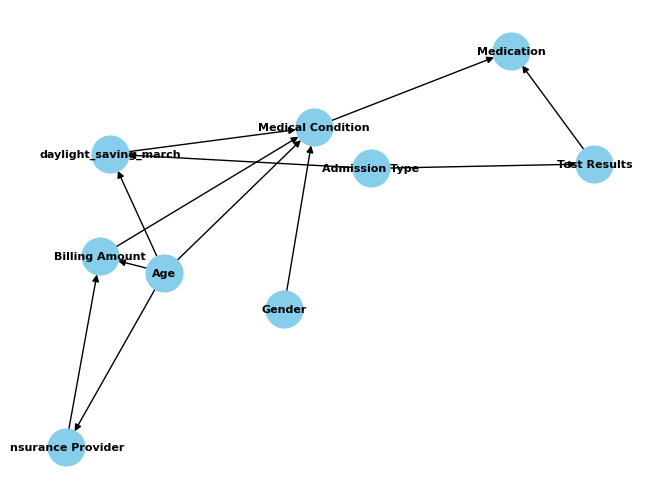

In [218]:
graph_variables = ['Age', 'Gender', 'Medical Condition',
             'Insurance Provider', 'Billing Amount', 'Admission Type', 
             'Medication', 'Test Results', 'daylight_saving_march']

G = nx.DiGraph()
G.add_nodes_from(graph_variables)

edges = [
    ('daylight_saving_march', 'Medical Condition'),
    ('Age', 'Medical Condition'),
    ('Age', 'daylight_saving_march'),
    ('Gender', 'Medical Condition'),
    ('Admission Type', 'daylight_saving_march'),
    ('Medical Condition', 'Medication'),
    ('Age', 'Insurance Provider'),
    ('Admission Type', 'Test Results'),
    ('Billing Amount', 'Medical Condition'),
    ('Age', 'Billing Amount'),
    ('Insurance Provider', 'Billing Amount'),
    ('Test Results', 'Medication')
]

G.add_edges_from(edges)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_size=8, node_size=700, node_color='skyblue', font_color='black', font_weight='bold', arrowsize=10)

plt.show()

# Exploratory Data Analysis - 15% of the grade

Testing correlations/conditional independences (15% grade, follow Tutorial 1&2)

Find all paths from between two nodes: ```daylight_saving_march``` and ```Medical Condition```.

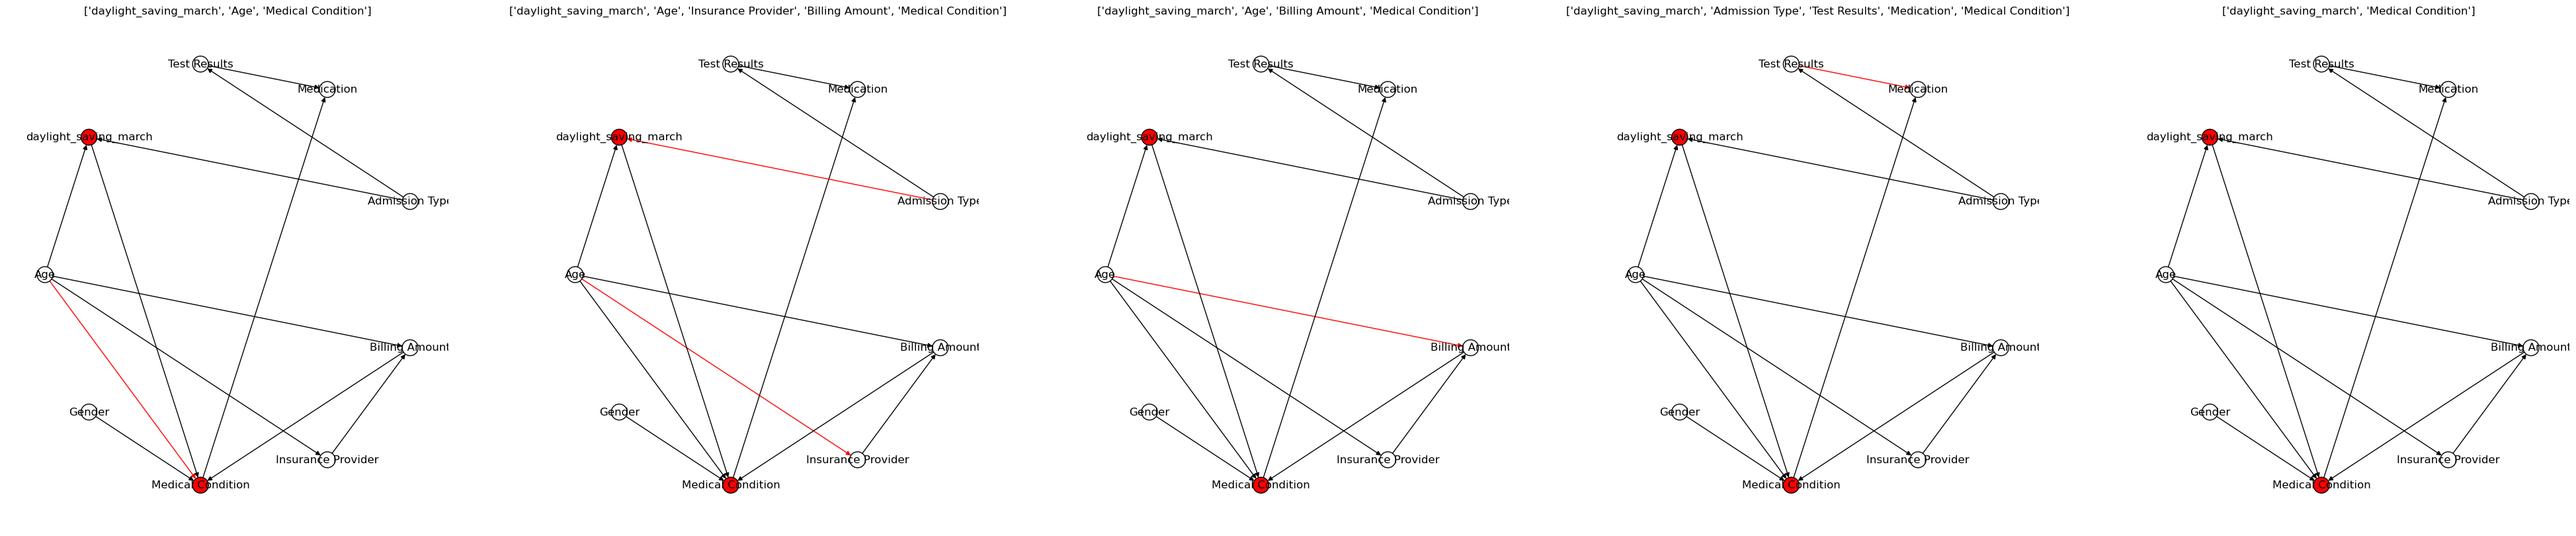

In [219]:
all_paths = list(nx.all_simple_paths(G.to_undirected(), source='daylight_saving_march', target='Medical Condition'))

fig, axs = plt.subplots(nrows=1, ncols=len(all_paths), figsize=(50, 10))
for path, ax in zip(all_paths, axs):
    edges_on_path = [(source, target) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if edge in edges_on_path else 'black' for edge in G.to_undirected().edges()]
    nx.draw_shell(G, with_labels=True, node_color=['w', 'w', 'r', 'w', 'w', 'w', 'w', 'w', 'r'], edgecolors='black', ax=ax, edge_color=edge_color)
    ax.set_title(path)

In [220]:
from itertools import combinations

X = ['daylight_saving_march']
Y = ['Medical Condition']

Z = [variable for variable in graph_variables if variable not in X + Y]

all_comb = []
for r in range(1, len(Z) + 1):
    all_comb.extend(combinations(Z, r))

# all will be false because they have a direct edge right now in the graph
for combination in all_comb:
    print('Node daylight_saving_march and Medical Condition are d-separated by {}: {}'.format(path, nx.algorithms.d_separated(G=G, x=set(['daylight_saving_march']), y=set(['Medical Condition']), z=set(combination))))

Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_march and Medical Condition are d-separated by ['daylight_saving_march', 'Medical Condition']: False
Node daylight_saving_mar

## Independence tests

In [221]:
from itertools import permutations
import pingouin as pg

def test_all(df, vars):
    # Marginal
    for var1, var2 in permutations(vars, 2):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
        print('{} and {}: p-value is {}'.format(var1, var2, p_val))

    # Conditional
    for var1, var2, cond in permutations(vars, 3):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        print('{} and {} given {}: p-value is {}'.format(var1, var2, cond, p_val))

In [222]:
def encode_categoricals(df):
    from sklearn.preprocessing import LabelEncoder

    label_encoder = LabelEncoder()

    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = label_encoder.fit_transform(df[column])
            
    return df

In [223]:
# in order to have the partial_corr independence test work we need to have numericals => encode categorical data
df_encoded = encode_categoricals(filtered_df)
df_encoded

,Age,Gender,Blood Type,Medical Condition,Date of Admission,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results,daylight_saving_march,daylight_saving_before_march
6,82,1,2,0,542,2,39593.435761,2,2,0,0,1
11,23,0,7,0,134,3,6185.903530,1,3,1,1,0
27,74,0,2,0,579,2,12680.730521,1,2,0,1,0
29,35,0,6,0,920,4,18393.421751,1,2,1,0,0
41,81,1,2,0,623,2,22519.336178,1,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9958,19,0,4,0,717,2,21208.288062,2,1,2,0,1
9965,31,1,4,0,668,1,11621.731148,0,3,0,0,0
9985,72,1,2,0,198,2,27476.721751,2,2,1,0,0
9992,37,1,6,0,56,4,8296.299322,2,4,2,0,1


In [224]:
test_all(df_encoded, graph_variables)

Age and Gender: p-value is 0.7760666269181379
Age and Medical Condition: p-value is nan
Age and Insurance Provider: p-value is 0.47184817242273214
Age and Billing Amount: p-value is 0.20286025902825466
Age and Admission Type: p-value is 0.4904876164223281
Age and Medication: p-value is 0.2925146574013778
Age and Test Results: p-value is 0.5667552999374726
Age and daylight_saving_march: p-value is 0.9149406511550904
Gender and Age: p-value is 0.7760666269181379
Gender and Medical Condition: p-value is nan
Gender and Insurance Provider: p-value is 0.5513931528362324
Gender and Billing Amount: p-value is 0.9171318174904896
Gender and Admission Type: p-value is 0.10393436764736116
Gender and Medication: p-value is 0.8655045208235158
Gender and Test Results: p-value is 0.2640912975671123
Gender and daylight_saving_march: p-value is 0.9533595637080884
Medical Condition and Age: p-value is nan
Medical Condition and Gender: p-value is nan
Medical Condition and Insurance Provider: p-value is na

# Identify estimands for backdoor, frontdoor criterion and IVs - 20% of the grade

If they apply, or explain why they don't apply (20% grade, follow Tutorial 3 and 4)

### Backdoor Criterion

The backdoor criterion allows us to identify the variables on which we need to condition to calculate our causal estimates. We identify these variables by looking at 'backdoor' paths from the treatment variable.

Given a CBN $(G = (\mathbf{V}, \mathbf{E}), p)$ and a distinct pair of variables $X_i, Y_j \in \mathbf{V}$, a set $\mathbf{Z} \subseteq \mathbf{V} \setminus \{i,j\}$ satisfies the
**backdoor criterion** for estimating the causal effect of $X_i$ on $X_j$ if:
- $\mathbf{Z}$ does not contain any descendant of $i$, $Desc(i) \cap \mathbf{Z} = \emptyset$, **and**
- $\mathbf{Z}$ blocks all backdoor paths from $i$ to $j$ (all paths that start with an arrow into $i \gets ... j$)


In [225]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

df_encoded.head()

# creating a copy of our graph G that is undirected
H = G.to_undirected()
all_possible_paths = list(nx.all_simple_paths(H, 'daylight_saving_march', 'Medical Condition'))
for path in all_possible_paths:
    print(path)

['daylight_saving_march', 'Age', 'Medical Condition']
['daylight_saving_march', 'Age', 'Insurance Provider', 'Billing Amount', 'Medical Condition']
['daylight_saving_march', 'Age', 'Billing Amount', 'Medical Condition']
['daylight_saving_march', 'Admission Type', 'Test Results', 'Medication', 'Medical Condition']
['daylight_saving_march', 'Medical Condition']


In [226]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(G, 'daylight_saving_march','Medical Condition')

In [227]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

['daylight_saving_march', 'Age', 'Medical Condition']
['daylight_saving_march', 'Age', 'Insurance Provider', 'Billing Amount', 'Medical Condition']
['daylight_saving_march', 'Age', 'Billing Amount', 'Medical Condition']
['daylight_saving_march', 'Admission Type', 'Test Results', 'Medication', 'Medical Condition']


In [228]:
# we create a pandas dataframe to track the path and its colliders and non-colliders
adjustment_variables = pd.DataFrame(columns=['path', 'colliders', 'non_colliders'])

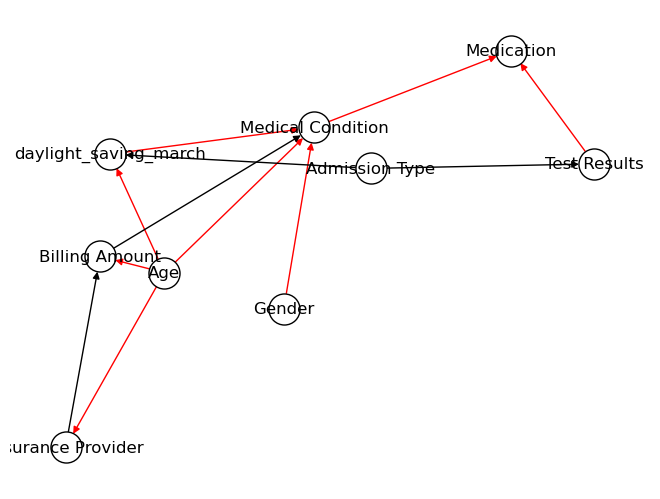

In [229]:
colors = ['r', 'r', 'r', 'r', 'r', 'r', 'black', 'black', 'black', 'black']
nx.draw(G, pos= pos, with_labels=True, node_size=500, node_color='w', edgecolors = 'black', edge_color =colors)
nx.write_gml(G, "backdoor_criterion_graph.gml")

In [230]:
def get_adjustment_variables(path):
    # we create empty (for now) lists for our colliders and non-colliders
    # we also create a variable for the length of the path
    colliders = np.array([])
    non_colliders = []
    path_len = len(path)

    # we loop through adjacent variables on the path, ignoring the source and target variables as potential colliders
    for node0, node1, node2 in zip(path[0:path_len-2], path[1:path_len-1], path[2:]):
        # if there is an arrow pointing into node1 from both sides on the path, it is a collider
        if G.has_edge(node0, node1) and G.has_edge(node2, node1):
            colliders = np.append(colliders, list(nx.descendants(G,node1)) + [node1]) # so we add it (and all its descendants) to the list
    # we flatten the list of list
    colliders = colliders.flatten()
    # any node on the path (excluding the source and target) that is not a collider is a non-collider
    non_colliders = [x for x in path[1:-1] if x not in colliders]
    # finally, we add the information to our dataframe, with the path, colliders, and non-colliders
    adjustment_variables.loc[len(adjustment_variables.index)] = [path, colliders, non_colliders] 
    return adjustment_variables


get_adjustment_variables(backdoor_paths[0])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Medical Condition]",[],[Age]


We now can see that we need either:

1. Not to condition on $Medicatioin$ or its descendants [None], or
2. Condition on at least one of [Age, Medical Condition]

In [231]:
get_adjustment_variables(backdoor_paths[1])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Medical Condition]",[],[Age]
1,"[daylight_saving_march, Age, Insurance Provide...",[],"[Age, Insurance Provider, Billing Amount]"


We now can see that we need either:

1. Not to condition on $Medication$ or its descendants [None], or
2. Condition on at least one of the non-colliders: ...

In [232]:
get_adjustment_variables(backdoor_paths[2])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Medical Condition]",[],[Age]
1,"[daylight_saving_march, Age, Insurance Provide...",[],"[Age, Insurance Provider, Billing Amount]"
2,"[daylight_saving_march, Age, Billing Amount, M...",[],"[Age, Billing Amount]"


We now can see that we need either:

1. Not to condition on $Medication$ or its descendants [None], or
2. Condition on at least one of the non-colliders: ...

In [233]:
get_adjustment_variables(backdoor_paths[3])

,path,colliders,non_colliders
0,"[daylight_saving_march, Age, Medical Condition]",[],[Age]
1,"[daylight_saving_march, Age, Insurance Provide...",[],"[Age, Insurance Provider, Billing Amount]"
2,"[daylight_saving_march, Age, Billing Amount, M...",[],"[Age, Billing Amount]"
3,"[daylight_saving_march, Admission Type, Test R...",[Medication],"[Admission Type, Test Results]"


There are no colliders on this path, so we need to condition on Admission type.

DoWhy can find sets satisfying the backdoor criterion automatically. We simply provide it with the graph (in .gml format). We also need to provide it with data, but since we are only worried about the backdoor criterion for now, we can give it meaningless data (remember: the estimands are graph-specific, and don't rely on the data).

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['daylight_saving_march'] on outcome ['Medical Condition']
INFO:dowhy.utils.plotting:Pygraphviz installation not found, falling back to networkx plotting. For better looking plots, consider installing pygraphviz. Note This requires both the Python pygraphviz package (``pip install pygraphviz``) and the shared system library (e.g. ``brew install graphviz`` or ``apt-get install graphviz``)


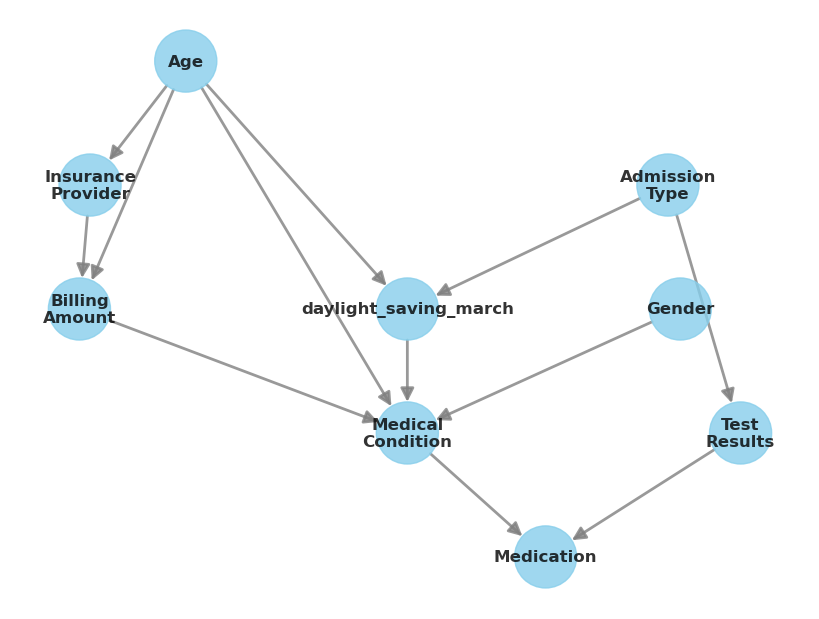

In [234]:
import dowhy
from dowhy import CausalModel


# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
    data = df_encoded,
    treatment='daylight_saving_march', 
    outcome='Medical Condition',
    graph=gml_graph
)
model.view_model()

In [235]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:['Admission Type']
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                      
────────────────────────(E[Medical Condition|Age])
d[daylight_saving_march]                          
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Medical Condition then P(Medical Condition|daylight_saving_march,Age,U) = P(Medical Condition|daylight_saving_march,Age)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢        d                            ⎛        d                             
E⎢─────────────────(Medical Condition)⋅⎜─────────────────([daylight_saving_mar
 ⎣d[Admission Type]                    ⎝d[Admission Type]                     

     -1⎤
    ⎞  ⎥
ch])⎟  ⎥
    ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Medical Condition then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we r

In [236]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': ('Insurance Provider',
   'Gender',
   'Test Results',
   'Admission Type',
   'Billing Amount',
   'Age')},
 {'backdoor_set': ('Age',)}]

### Frontdoor Criterion

The frontdoor criterion is similar to the backdoor criterion, only now we move along 'forward' paths rather than 'backwards' paths. The below definition and example are from: https://medium.data4sci.com/causal-inference-part-xii-front-door-criterion-38bec5172f3e.

A set of variables **Z** is said to satisfy the front-door criterion relative to an ordered pair of variables ($X_i$, $X_j$), if:
1. **Z** intercepts all directed paths from $X_i$ to $X_j$
2. There is no unblocked backdoor path from $X_i$ to **Z**
3. All backdoor paths from **Z** to $X_j$ are blocked by $X_i$

Let's consider the same graph as in week 3 and identify possible frontdoor criterion adjustment sets for the effect of $X$ on $Y$.

INFO:dowhy.utils.plotting:Pygraphviz installation not found, falling back to networkx plotting. For better looking plots, consider installing pygraphviz. Note This requires both the Python pygraphviz package (``pip install pygraphviz``) and the shared system library (e.g. ``brew install graphviz`` or ``apt-get install graphviz``)


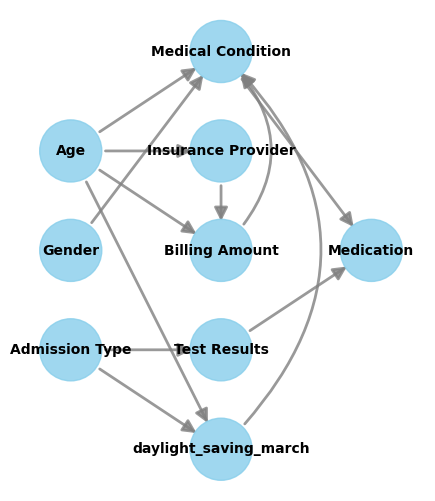

In [241]:
# we extract the CausalGraph object from our CausalModel object
our_causal_graph = model._graph
our_causal_graph.view_graph()

Now we can find an adjustment set that satisfies the frontdoor criterion. We first need all directed paths from $X$ to $Y$, as our adjustment set needs to intercept all such paths.

In [242]:
# function for finding all directed paths between the two nodes given
our_causal_graph.get_all_directed_paths('daylight_saving_march', 'Medical Condition')

NodeNotFound: source node d not in graph

In [243]:
# function that finds backdoor paths from the first node to the second
x_w_backdoor_paths = our_causal_graph.get_backdoor_paths('daylight_saving_march', # the mediator)
x_w_backdoor_paths

NodeNotFound: source node d not in graph

In [244]:
# list for keeping track of which paths are blocked
path_is_blocked = []

# looping through the backdoor paths from X to W
for path in x_w_backdoor_paths:
    # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
    # in this case, we are not conditioning on any nodes, so give it the empty set
    path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = []))

path_is_blocked

NameError: name 'x_w_backdoor_paths' is not defined

In [ ]:
w_y_backdoor_paths = our_causal_graph.get_backdoor_paths('W', 'Y')
w_y_backdoor_paths

In [ ]:
# list for keeping track of which paths are blocked
path_is_blocked = []

# looping through the backdoor paths from W to Y
for path in w_y_backdoor_paths:
    # the is_blocked function checks with a path is blocked when conditioning on the set conditioned_nodes
    # in this case, we are conditioning on the set [X]
    path_is_blocked.append(our_causal_graph.is_blocked(path, conditioned_nodes = ['X']))

path_is_blocked

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

# Estimate the causal effects - 15% of the grade

(e.g. linear, inverse propensity weighting, two stage linear-regression etc) to the estimands you have previously identified (15% grade, follow Tutorial 4)

In [255]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)


INFO:dowhy.causal_identifier.auto_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier.auto_identifier:Instrumental variables for treatment and outcome:['Admission Type']
INFO:dowhy.causal_identifier.auto_identifier:Frontdoor variables for treatment and outcome:[]


Let's use the set identified by the backdoor criterion. We can thus estimate the effect of daylight_saving_march on Medical Condition when we condition on Age.

Let's first try estimate the effect without conditioning on these extra variables. Suppose we expect (know) that the effect is linear. We can then apply a linear estimator to find the effect. We will use linear regression.

In [246]:
# we first use only v0 and y
# we need to reshape them into the correct shape for our linear regression function
num_samples = df_encoded.shape[0]
v0_vals = df_encoded['daylight_saving_march'].values.reshape(num_samples, 1)
y_vals = df_encoded['Medical Condition'].values.reshape(num_samples, 1)

In [247]:
# we import the LinearRegression object from sklearn
from sklearn.linear_model import LinearRegression

# we fit a linear regression model with v0 and y, and check what the estimated linear effect is
linear_regressor = LinearRegression() 
linear_regressor.fit(v0_vals, y_vals)
linear_regressor.coef_

array([[0.]])

In [250]:
W0_vals = df_encoded['Age'].values.reshape(num_samples, 1)
# we need to combine all of the variables we're including into one array
v0_W0_W1_vals = np.concatenate((v0_vals, W0_vals), axis = 1)
v0_W0_W1_vals

array([[ 0, 82],
       [ 1, 23],
       [ 1, 74],
       ...,
       [ 0, 72],
       [ 0, 37],
       [ 0, 39]])

In [251]:
# we fit the linear regression with the extra variables included
linear_regressor.fit(v0_W0_W1_vals, y_vals)
linear_regressor.coef_

array([[0., 0.]])

In [252]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:linear_regression
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Medical Condition~daylight_saving_march+Age+daylight_saving_march*Insurance Provider+daylight_saving_march*Gender+daylight_saving_march*Billing Amount


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                      
────────────────────────(E[Medical Condition|Age])
d[daylight_saving_march]                          
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Medical Condition then P(Medical Condition|daylight_saving_march,Age,U) = P(Medical Condition|daylight_saving_march,Age)

## Realized estimand
b: Medical Condition~daylight_saving_march+Age+daylight_saving_march*Insurance Provider+daylight_saving_march*Gender+daylight_saving_march*Billing Amount
Target units: ate

## Estimate
Mean value: 0.0

Causal Estimate is 0.0


In [253]:
# using the backdoor adjustment set and propensity score stratification
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:propensity_score_stratification
INFO:dowhy.causal_estimator:Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: Medical Condition~daylight_saving_march+Age
INFO:dowhy.causal_estimator:'num_strata' selected as 83.4
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 41
INFO:dowhy.causal_estimator:Less than half the strata have at least 10 data points. Selecting fewer number of strata.
INFO:dowhy.causal_estimator:'num_strata' selected as 20


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                      
────────────────────────(E[Medical Condition|Age])
d[daylight_saving_march]                          
Estimand assumption 1, Unconfoundedness: If U→{daylight_saving_march} and U→Medical Condition then P(Medical Condition|daylight_saving_march,Age,U) = P(Medical Condition|daylight_saving_march,Age)

## Realized estimand
b: Medical Condition~daylight_saving_march+Age
Target units: ate

## Estimate
Mean value: 0.0

Causal Estimate is 0.0


In [254]:
# using the instrumental variables
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

INFO:dowhy.causal_model:instrumental_variable
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡       d                          ⎤  -1⎡       d                            
E⎢───────────────(Medical Condition)⎥⋅E  ⎢───────────────(daylight_saving_marc
 ⎣dAdmission Type                   ⎦    ⎣dAdmission Type                     

  ⎤
h)⎥
  ⎦
Estimand assumption 1, As-if-random: If U→→Medical Condition then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we remove {Admission Type}→{daylight_saving_march}, then ¬({Admission Type}→Medical Condition)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['daylight_saving_march'] is affected in the same way by common causes of ['daylight_saving_march'] and ['Medical Condition']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢        d                            ⎛        d                             
E⎢─────────────────(Medical Condition)⋅⎜─────────────────([daylight_saving_mar
 ⎣d[Admission Type]                    ⎝d[Admission Type]                     

     -1⎤
    ⎞  ⎥
ch])⎟  ⎥
    ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Medical Condition then ¬(U →→{Admission Type})
Estimand assumption 2, Exclusion: If we remove {Admission Type}→{daylight_saving_march}, then ¬({Admission Type}→Medical Condition)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡       d                          ⎤  -1⎡       d                            
E⎢───────────────(Medical Condition)⎥⋅E  ⎢───────────────(dayli

# Causal discovery results - 20% of the grade

for at least one constraint-based (e.g. SGS, PC) and score-based algorithm (e.g. GES), explain why it works or it doesn't and what is identifiable (20% grade, follow Tutorials 5 and 6)

# Validation and sensitivity analysis - 20% of the grade

(e.g. refutation analysis in DoWhy) and Discussion on the assumptions and results (20% grade)